# Handwritten Digits Classifier with Improved Accuracy using Data Augmentation

In previous steps, we trained a model that could recognize handwritten digits using the MNIST dataset. We were able to achieve above 98% accuracy on our validation dataset. However, when you deploy the model in an Android app and test it, you probably noticed some accuracy issue. Although the app was able to recognize digits that you drew, the accuracy is probably way lower than 98%.

In this notebook we will explore the couse of the accuracy drop and use data augmentation to improve deployment accuracy.

## Preparation

Let's start by importing TensorFlow and other supporting libraries that are used for data processing and visualization.

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

print(tf.__version__)

2.6.0


Import the MNIST dataset

In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a color dimension to the images in "train" and "validate" dataset to
# leverage Keras's data augmentation utilities later.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

11501568/11490434 [==============================] - 0s 0us/step


Define an utility function so that we can create quickly create multiple models with the same model architecture for comparison.


In [5]:
def create_model():
  model = keras.Sequential(
      [
       keras.layers.InputLayer(input_shape=(28,28,1)),
       keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
       keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu),
       keras.layers.MaxPooling2D(pool_size=(2,2)),
       keras.layers.Dropout(0.25),
       keras.layers.Flatten(),
       keras.layers.Dense(10, activation=tf.nn.softmax)
      ]
  )
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Confirm that our model can achieve above 98% accuracy on MNIST Dataset.

In [6]:
base_model = create_model()
base_model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 43s 7ms/step - loss: 0.1418 - accuracy: 0.9569 - val_loss: 0.0580 - val_accuracy: 0.9815
Epoch 2/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0544 - accuracy: 0.9836 - val_loss: 0.0515 - val_accuracy: 0.9829
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0414 - accuracy: 0.9869 - val_loss: 0.0385 - val_accuracy: 0.9875
Epoch 4/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0324 - accuracy: 0.9900 - val_loss: 0.0362 - val_accuracy: 0.9891
Epoch 5/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.0373 - val_accuracy: 0.9884


## Troubleshoot the accuracy drop

Let's see the digit images in MNIST again and guess the cause of the accuracy drop we experienced in deployment.

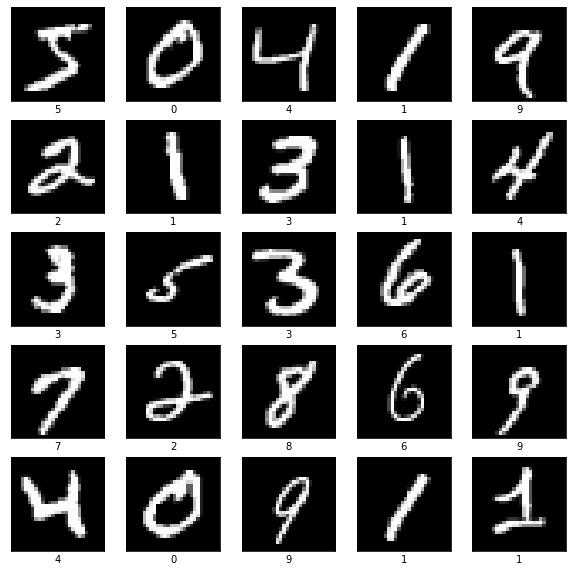

In [7]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(train_images[i], axis=2), cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

We can see from the 25 images above that the digits are about the same size, and they are in the center of the images. Let's verify if this assumption is true across the MNIST dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b45cf50d0>,
      dtype=object)

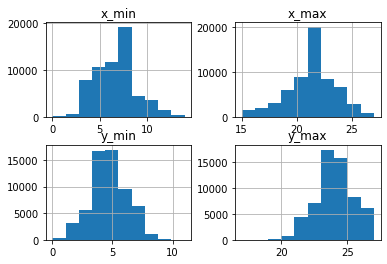

In [9]:
# An utility function that returns where the digit is in the image.
def digit_area(mnist_image):
  # Remove the color axes
  mnist_image = np.squeeze(mnist_image, axis=2)  

  # Extract the list of columns that contain at least 1 pixel from the digit
  x_nonzero = np.nonzero(np.amax(mnist_image, 0))
  x_min = np.min(x_nonzero)
  x_max = np.max(x_nonzero)

  # Extract the list of rows that contain at least 1 pixel from the digit
  y_nonzero = np.nonzero(np.amax(mnist_image, 1))
  y_min = np.min(y_nonzero)
  y_max = np.max(y_nonzero)

  return [x_min, x_max, y_min, y_max]

# Calculate the area containing the digit across MNIST dataset
digit_area_rows = []
for image in train_images:
  digit_area_row = digit_area(image)
  digit_area_rows.append(digit_area_row)
digit_area_df = pd.DataFrame(
    digit_area_rows,
    columns=['x_min', 'x_max', 'y_min', 'y_max']
)
digit_area_df.hist()

Now for the histogram, you can confirm that the digit in MNIST images are fitted nicely in an certain area at the center of the images.

[MNIST Range](https://download.tensorflow.org/models/tflite/digit_classifier/mnist_range.png)

However, when you wrote digits in your Android app, you probably did not pay attention to make sure your digit fit in the virtual area that the digits appear in MNIST dataset. The Machine Learning Model have not seen such data before so it performed poorly, especially when you wrote a a digit that was off the center of the drawing pad.

Let's add some data augmentation to the MNIST dataset to verify if our assumption is true. We will distort our MNIST dataset by adding:
* Rotation
* Width and height shift
* Shear
* Zoom

In [10]:
# Define data augmentation

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.2
)

# Generate augmented data from MNIST dataset
train_generator = datagen.flow(train_images, train_labels)
test_generator = datagen.flow(test_images, test_labels)

Let's see what our digit images look like after augmentation. You can see that we now clearly have much more variation on how the digits are placed in the images.

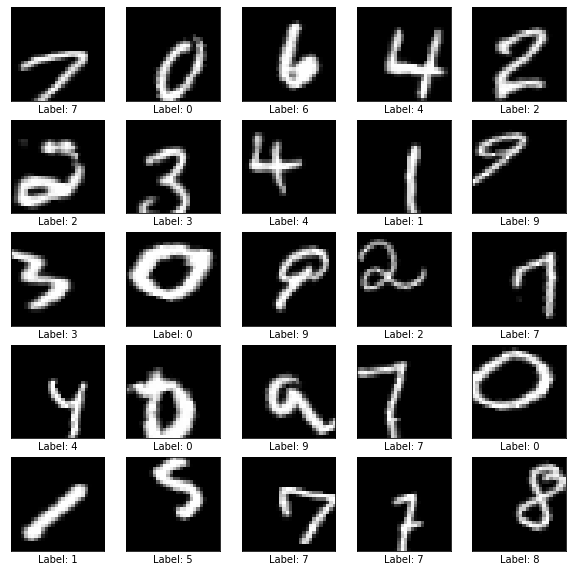

In [12]:
augmented_images, augmented_labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(augmented_images[i], axis=2), cmap=plt.cm.gray)
  plt.xlabel('Label: %d' % augmented_labels[i])
plt.show()

Let's evaluate the digit classifier model that we trained earlier on this augmented test dataset and see if it makes accuracy drop.

In [13]:
base_model.evaluate(test_generator)

313/313 [==============================] - 6s 18ms/step - loss: 5.6356 - accuracy: 0.3272


[5.635581970214844, 0.3271999955177307]

You can see that accuracy significantly dropped to below 40% in augmented test dataset.

## Improve accuracy with data augmentation

Now let's train our model using augmented dataset to make it perform better in deployment.

In [14]:
improved_model = create_model()
improved_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.9860 - accuracy: 0.6849 - val_loss: 0.5181 - val_accuracy: 0.8516
Epoch 2/5
1875/1875 [==============================] - 40s 22ms/step - loss: 0.5070 - accuracy: 0.8491 - val_loss: 0.3765 - val_accuracy: 0.8877
Epoch 3/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4145 - accuracy: 0.8758 - val_loss: 0.3064 - val_accuracy: 0.9102
Epoch 4/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3671 - accuracy: 0.8896 - val_loss: 0.2749 - val_accuracy: 0.9219
Epoch 5/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3275 - accuracy: 0.9017 - val_loss: 0.2593 - val_accuracy: 0.9249


We can see that as the models saw more distorted digit images during training, its accuracy evaluated distorted test digit images were significantly improved to about 90%.

## Convert to TensorFlow Lite

Let's convert the improved model to TensorFlow Lite and redeploy the Android app.

In [15]:
# Convert Keras model to TF Lite format and quantize.

converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the Quantized Model to file to the Downloads Directory
f = open('mnist-improved.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist-improved.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpm1ypiyxg/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>